# **Parsing Tree Data for Wilsonville's Street Trees**
---
> What are the characteristics of Wilsonville's street tree population and how were Wilsonville's street trees affected by the 2020 ice storm?


 ## Housekeeping

In [535]:
# Import packages adn dependecies
import arcpy
import math
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2

import seaborn as sns; sns.set_theme('notebook', 'whitegrid', 'mako')
import matplotlib.pyplot as plt

In [536]:
# Set arcpy environment
arcpy.env.workspace =r"C:\Users\rhuerta\Documents\ArcGIS\Projects\GeoCorrectionTest\GeoCorrectionTest.gdb"

In [537]:
#Create custom palette from RGB values that Carl sent me
status_order = ['Removed, stump present', 'Removed, no stump', 'No damage', 'Damaged, needs removal', 
                'Damaged, may need removal - follow up required']
custom_palette = [(205, 170, 102), (137, 68, 68), (114, 137, 68), (255, 170, 0.0), (168, 0, 102)]
custom_palette = [tuple([x/255 for x in i]) for i in custom_palette]

palette_dict = dict(zip(status_order, custom_palette))


### *Function  definitions*

In [538]:
# Define function to import ArcPro table as panda data frame
def table_to_data_frame(in_table, input_fields=None, where_clause=None):
    """Function will convert an arcgis table into a pandas dataframe with an object ID index, and the selected
    input fields using an arcpy.da.SearchCursor."""
    OIDFieldName = arcpy.Describe(in_table).OIDFieldName
    if input_fields:
        final_fields = [OIDFieldName] + input_fields
    else:
        final_fields = [field.name for field in arcpy.ListFields(in_table)]
    data = [row for row in arcpy.da.SearchCursor(in_table, final_fields, where_clause=where_clause)]
    fc_dataframe = pd.DataFrame(data, columns=final_fields)
    fc_dataframe = fc_dataframe.set_index(OIDFieldName, drop=True)
    return fc_dataframe

In [539]:
#Define classification function
def classScheme(start_val, end_val, multiplier, roundTo = 0):
    """Function will take start and end float values and a multiplier float, and return a list of exponential values between 0 
    and end value using the multiplier. The end value is not included and roundTo parameter is optional """
    categories = []
    x = start_val
    while x<= end_val:
        categories.append(x)
        x = round(x * multiplier, roundTo)
    
    return categories

In [540]:
#Define condition generator
def conditionGen(class_scheme, df, column):
    """Function will take a list of float values and interpret them into a list of conditions and values to populate a 
    dataframe column. Returns a list of pandas slice objects  and a list of values meant to be used with
    the 'df['column'] = np.select(conditions, values)' syntax to create a classification column"""
    
    conditions = []
    values = []
    
    for cat in range(len(class_scheme)):
        if cat == 0:
            conditions.append(df.loc[:,column]<=class_scheme[cat])
            values.append(f'0 - {class_scheme[cat]}')
        if cat == len(class_scheme)-1:
            conditions.append((df.loc[:,column]>class_scheme[cat]))
            values.append(f'{class_scheme[cat]} <')
        else:
            conditions.append((df.loc[:,column]>class_scheme[cat]) & (df.loc[:,column]<=class_scheme[cat+1]))
            values.append(f'{class_scheme[cat]} - {class_scheme[cat +1]}')
    
    return conditions, values
    

In [541]:
#Define function for labeling bar cat plots
def catLabel(catp, label_values, height_cutoff = math.inf, add_height = 50, fontsize = 'large', percent = True):
    """Function will accept a matplot lib categorical plot and list of string to be used as labels. Labels must be in the
    same order as the patches on the plot. The hieght cutoff parameter determines the height at which labesl will be placed 
    inside the patch rather than above it. Add height determines how much space is between the label and the patch when the 
    label is above the patch. If percent=True, the labels will have a % symbol after it, if percent=False, the label will not 
    have % after it."""
    
    spots = zip(catp.ax.patches, label_values)
    
    if percent == True:
        tag = '%'
    else:
        tag = ''
    
    for spot in spots:
        height = spot[0].get_height()

        if math.isnan(height):
            height = 0
            catp.ax.text(spot[0].get_x() + spot[0].get_width()/2, height + add_height, (str(round(spot[1], 2))+tag), 
                         rotation = 90, 
                         fontsize = fontsize, fontstyle = 'italic')
        if height > height_cutoff:
            catp.ax.text(spot[0].get_x() + spot[0].get_width()/2, (height/2) + 3 , (str(round(spot[1], 2))+tag), 
                         rotation = 90, 
                         fontsize = fontsize, fontstyle = 'italic', color = 'white' )
        else:  
            catp.ax.text(spot[0].get_x() + spot[0].get_width()/2, height + add_height, (str(round(spot[1], 2))+tag), 
                         rotation = 90, 
                         fontsize = fontsize, fontstyle = 'italic')

### *Import and clean-up tree data*

In [542]:
# Import tree data from ArcPro into pandas df
tree_df = table_to_data_frame("Carte_Park_Trees_Table", input_fields= ["CarteID", "ScientificName", "Genus", "TreeType",
                                                                       "tree_status", "Height", "DBH", "Health"])


In [543]:
# Clean up tree-df to exclude and empty scientific names field or empty tree_status fields
tree_df = tree_df[tree_df.tree_status != '']
tree_df = tree_df[tree_df.ScientificName !='']
tree_df = tree_df.dropna(subset = ['tree_status'])


In [544]:
# this is a table that was cleaned-up in arc-pro by my Carl
arc_pro_edit = table_to_data_frame("edited_trees", input_fields= ["CarteID", "ScientificName",  "tree_status", "Height", "DBH"])
arc_pro_edit

,CarteID,ScientificName,tree_status,Height,DBH
OBJECTID,,,,,
1,1301,Pyrus calleryana,"Removed, no stump",14.0,1.9
2,1525,Acer platanoides 'Emerald Queen',"Removed, no stump",32.0,12.0
3,1526,Acer platanoides 'Emerald Queen',"Removed, no stump",34.0,14.8
4,1537,Fraxinus oxycarpa,"Removed, stump present",35.0,10.2
5,1538,Fraxinus oxycarpa,"Removed, stump present",35.0,10.5
...,...,...,...,...,...
2611,55726,Chamaecyparis obtusa,"Removed, no stump",29.0,7.1
2612,55736,Pinus densiflora,"Removed, no stump",6.0,6.2
2613,55737,Pinus contorta contorta,"Removed, no stump",40.0,15.0


In [545]:
# make sure the table in arc rpo and the one in pandas ar identical
pd.concat([removed_trees, arc_pro_edit]).drop_duplicates(subset = ['CarteID'], keep=False)

,CarteID,ScientificName,Genus,TreeType,tree_status,Height,DBH,Health,removed,storm_dmg,removed_no_stump,DBH_tiers
OBJECTID,,,,,,,,,,,,
794,8334,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
899,9653,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
919,10110,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
986,11008,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
988,11048,,NaN,NaN,"Removed, no stump",NaN,2.0,NaN,NaN,NaN,NaN,NaN
1203,13971,,NaN,NaN,"Removed, no stump",3.0,NaN,NaN,NaN,NaN,NaN,NaN
1281,15078,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1282,15079,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1283,15080,,NaN,NaN,"Removed, no stump",NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Species Wide Stats

## *What is the breakdown for deciduous vs coniferous street trees?*

In [546]:
tree_df['TreeType'].value_counts()

Deciduous     20184
Coniferous     5812
Unknown           1
Name: TreeType, dtype: int64

In [547]:
tree_df['TreeType'].value_counts(normalize = True)

Deciduous     0.776397
Coniferous    0.223564
Unknown       0.000038
Name: TreeType, dtype: float64

## *What are the tree status categories breakdowns for all trees in Wilsonville?*

In [548]:
#Define category hierarchy for tree_status column
tree_df['tree_status'] = pd.Categorical(tree_df['tree_status'], ['Removed, stump present', 
                                                                 'Removed, no stump', 'No damage', 'Damaged, needs removal', 
                                                                 'Damaged, may need removal - follow up required'])

In [549]:
#Calculate the percentage for tree_status values
status_perc = (tree_df['tree_status'].value_counts(
    normalize=True)*100).reset_index().rename(
    columns = {'index':'tree_status', 'tree_status':'percent'}).sort_values(
    'tree_status')['percent'].tolist()

In [550]:
# Get count for each tree status value
tree_df['tree_status'].value_counts()

No damage                                         22885
Removed, no stump                                  1993
Removed, stump present                              605
Damaged, may need removal - follow up required      492
Damaged, needs removal                               22
Name: tree_status, dtype: int64

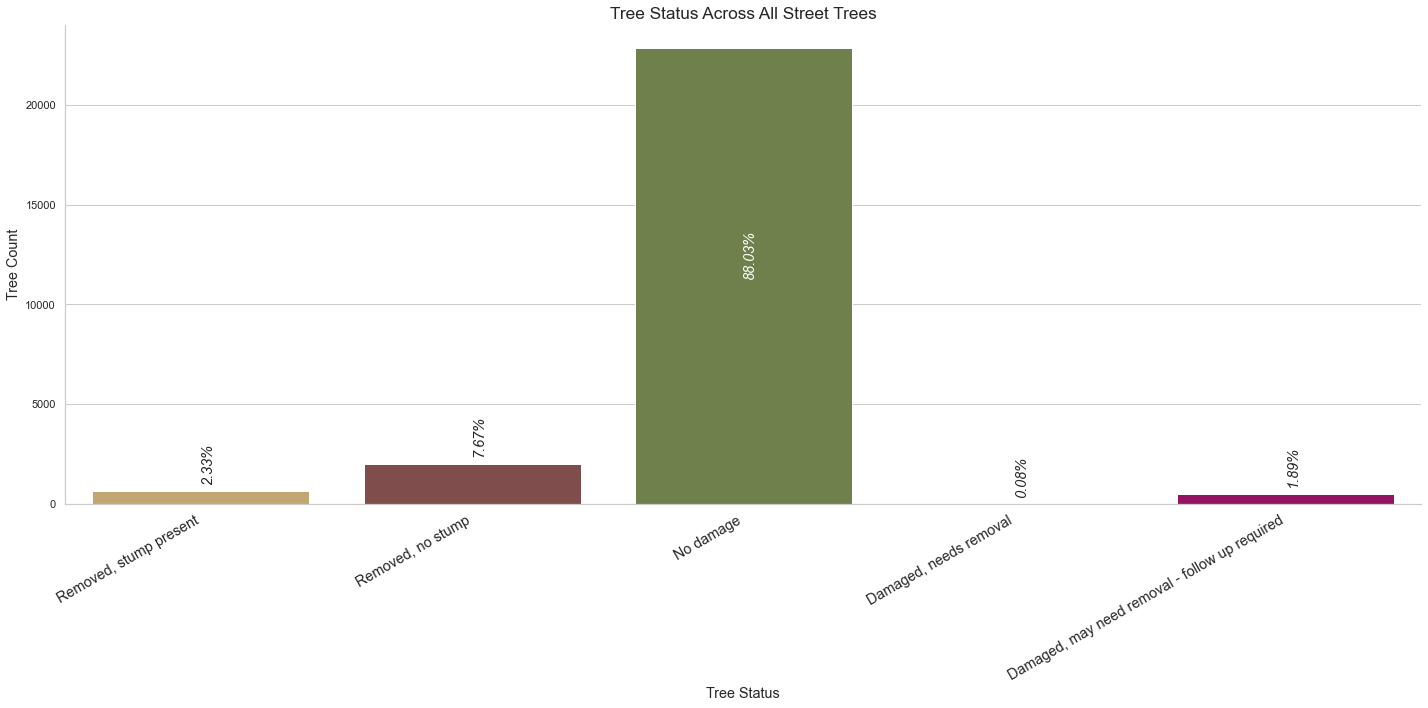

In [551]:
#Plot tree_status counts
catp = sns.catplot(x="tree_status", kind="count", palette = custom_palette, data= tree_df, height = 10, aspect = 2)

#label patches with percentages
catLabel(catp, status_perc, 2000, add_height = 500)

#Edit decorations
catp.ax.set_title('Tree Status Across All Street Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('Tree Status', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

## *Which tree species had the most individual trees removed?*

In [552]:
# Create 'removed' column within tree_df 
tree_df['removed'] = np.where((tree_df['tree_status'] == 'Removed, stump present')|
                              (tree_df['tree_status'] == 'Removed, no stump'), 'Removed', 'Not removed')

#Create df that only includes trees with a 'Removed' status
removed_trees = tree_df[tree_df['removed']=='Removed']

#Get the ten tree species with the highest count of 'Removed' trees
top_removed = removed_trees.groupby('ScientificName')['removed'].size().sort_values(ascending = False).reset_index(
    name = 'count').nlargest(10, 'count')

top_removed

,ScientificName,count
0,Acer rubrum,209
1,Pyrus calleryana,126
2,Acer palmatum,109
3,Betula papyrifera,94
4,Prunus cerasifera,92
5,Chamaecyparis obtusa,69
6,Prunus,61
7,"Pinus sylvestris ""Glauca Nana""",60
8,Pseudotsuga menziesii,58
9,Thuja plicata,56


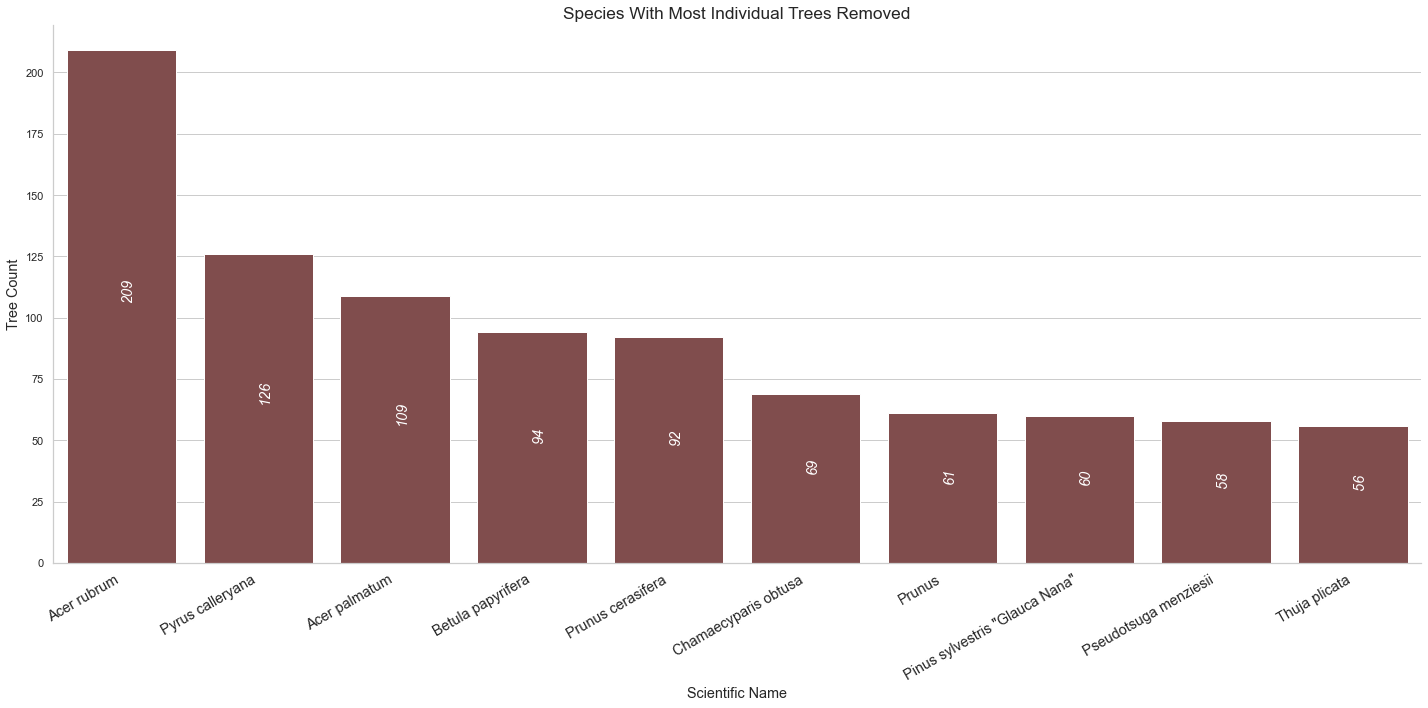

In [553]:
# Define the order the tree species will plotted by
species_order = top_removed['ScientificName']

#Define palette for the plot
palette = [palette_dict['Removed, no stump'] for x in range(len(species_order))]

#Plot the data
catp = sns.catplot(x="ScientificName", kind="count", palette = palette,order = species_order,
                   data= removed_trees[removed_trees['ScientificName'].isin(top_removed['ScientificName'])], 
                   height = 10, aspect = 2)

#Label the data
catLabel(catp, top_removed['count'].tolist(), 0, percent = False)

#Edit decorations
catp.ax.set_title('Species With Most Individual Trees Removed', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()

plt.show()

## *Which tree species with a population of at least 100 had the highest removal rate?*

In [554]:
# Get counts for scientific names
name_count = tree_df['ScientificName'].value_counts().reset_index().rename(
    columns = {'index': 'ScientificName', 'ScientificName': 'count'})

#Filter out any scientific names that have less than 100 value counts and apply filter to original tree_df
over_hundred = name_count[name_count['count']>=100]
over_hundred = tree_df[tree_df["ScientificName"].isin(over_hundred['ScientificName'])]


In [555]:
#Get normalized removal rates for any scientific name with counts 100 or over
over_hund_stats = (over_hundred.groupby("ScientificName")['removed'].value_counts(
    normalize = True)*100).sort_values(ascending = False)
over_hund_stats = over_hund_stats.reset_index(name = 'percent')

# Get scientific names with the highest normalized remova rates
top_ten_removed = over_hund_stats[over_hund_stats['removed'] == 'Removed'].nlargest(10, 'percent')

top_ten_removed

,ScientificName,removed,percent
66,Betula papyrifera,Removed,51.086957
68,Prunus cerasifera,Removed,34.074074
69,Betula pendula,Removed,30.898876
70,Picea glauca,Removed,22.279793
71,Prunus,Removed,20.748299
72,Pinus contorta,Removed,20.300752
73,"Pinus sylvestris ""Glauca Nana""",Removed,20.270270
74,Alnus rubra,Removed,19.819820
75,Pinus nigra,Removed,17.857143
76,Liquidambar styraciflua,Removed,17.543860


In [556]:
# Apply top ten removal rates filter to over_hundred df in perparation for plotting
over_hundred_top = over_hundred[(over_hundred['ScientificName'].isin(top_ten_removed['ScientificName']))]

# Concatenate all percentages into list for labelling
removed_perc = top_ten_removed['percent'].tolist()
not_removed_perc = [100-x for x in removed_perc]
removed_perc = removed_perc + not_removed_perc       

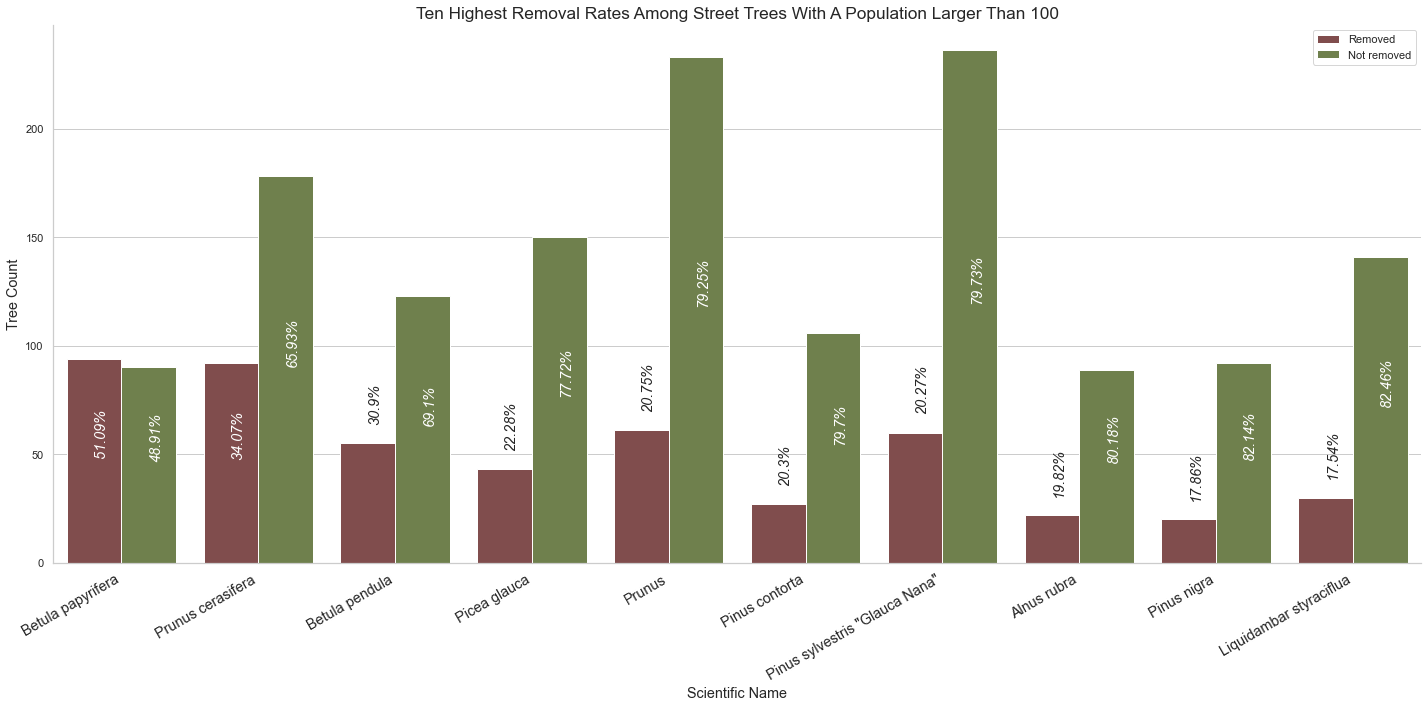

In [557]:
# Define species order for plotting
species_order = top_ten_removed['ScientificName']

# Define color palette
palette = [palette_dict['Removed, no stump'], palette_dict['No damage']]

# plot data
catp = sns.catplot(x="ScientificName", kind="count", palette = palette, hue = 'removed', hue_order = ['Removed', 'Not removed'],
                   order = species_order, legend = False,
                   data= over_hundred_top, height = 10, aspect = 2)

#Label data
catLabel(catp, removed_perc, 80, 10)

#Edit decorations
catp.ax.set_title('Ten Highest Removal Rates Among Street Trees With A Population Larger Than 100', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

## *Which tree species had the most individual trees that suffered damage that could be attributed to the 2020 ice storm?*

In [558]:
# create ice_dmg df that exclued and 'Removed, no stump' or 'No damage' trees
ice_dmg = tree_df[(tree_df['tree_status']!= 'Removed, no stump') & 
                             (tree_df['tree_status']!= 'No damage')]

# Get values counts for scientific names in ice_dmg df and show top ten
top_damaged = ice_dmg['ScientificName'].value_counts().reset_index(name = 'count').sort_values(by = 'count', ascending = False)
top_damaged = top_damaged.rename(columns = {'index': 'ScientificName'})
top_damaged = top_damaged.nlargest(10, 'count')
top_damaged

,ScientificName,count
0,Acer rubrum,167
1,Prunus cerasifera,70
2,Pyrus calleryana,63
3,Betula papyrifera,62
4,Zelkova serrata,62
5,Betula pendula,29
6,Fraxinus oxycarpa,28
7,Fraxinus pennsylvanica,27
8,Quercus coccinea,27
9,Quercus rubra,24


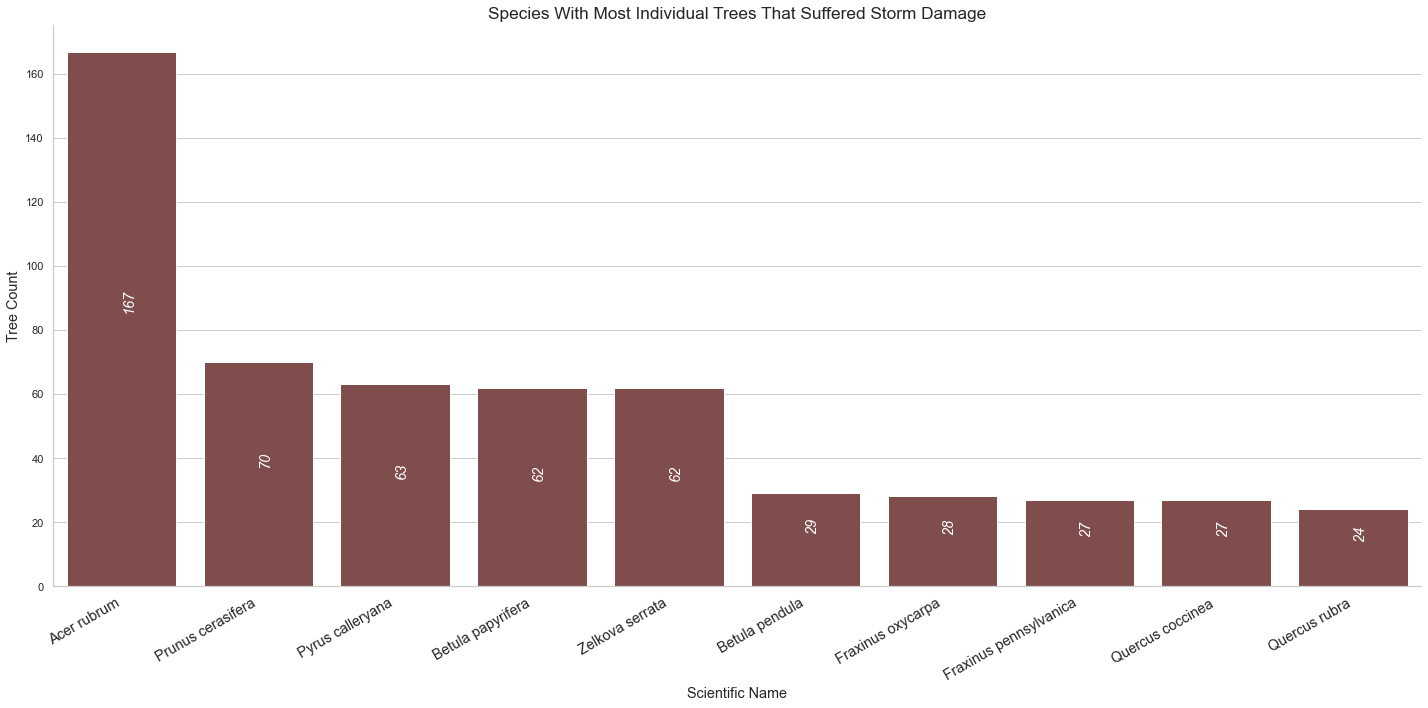

In [559]:
# Define order species willbe plotted in
species_order = top_damaged['ScientificName']

# Define color palette
palette = [palette_dict['Removed, no stump'] for x in range(len(species_order))]

# Plot data
catp = sns.catplot(x="ScientificName", kind="count", palette = palette,order = species_order,
                   data= ice_dmg[ice_dmg['ScientificName'].isin(top_damaged['ScientificName'])], 
                   height = 10, aspect = 2)

# Label patches
catLabel(catp, top_damaged['count'].tolist(), 0, percent = False)

# Edit decorations
catp.ax.set_title('Species With Most Individual Trees That Suffered Storm Damage', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

## *Which tree species with a population of at least 100 had the highest rate of potential storm damage?*

In [560]:
# Create a column for 'storm_dmg'
tree_df.loc[:,'storm_dmg'] = np.where((tree_df['tree_status'] != 'Removed, no stump') &
                              (tree_df['tree_status'] != 'No damage'), 'Storm damage', 'No storm damage')

# Filter tree_df to get scientifics names that occur at least 100 times
over_hundred = tree_df[tree_df["ScientificName"].isin(over_hundred['ScientificName'])]

In [561]:
# Get normalized storm damage rates and diplay top ten rates
over_hund_dmg = (over_hundred.groupby("ScientificName")['storm_dmg'].value_counts(
    normalize = True)*100).sort_values(ascending = False)
over_hund_dmg = over_hund_dmg.reset_index(name = 'percent')
top_ten_dmg = over_hund_dmg[over_hund_dmg['storm_dmg'] == 'Storm damage'].nlargest(10, 'percent')

top_ten_dmg

,ScientificName,storm_dmg,percent
67,Betula papyrifera,Storm damage,33.695652
68,Prunus cerasifera,Storm damage,25.925926
69,Betula pendula,Storm damage,16.292135
70,Fraxinus oxycarpa,Storm damage,13.592233
71,Quercus coccinea,Storm damage,11.344538
72,Cercis canadensis,Storm damage,10.000000
73,Prunus avium,Storm damage,9.844560
74,Zelkova serrata,Storm damage,8.446866
75,Pinus nigra,Storm damage,8.035714
76,Gleditsia triacanthos,Storm damage,7.582938


In [562]:
# Apply top ten damage rates filter to over_hundred df in perparation for plotting
over_hundred_dmg = over_hundred[(over_hundred['ScientificName'].isin(top_ten_dmg['ScientificName']))]
removed_dmg = top_ten_dmg['percent'].tolist()

# Concatenate all percentages into list for labelling
not_removed_dmg = [100-x for x in removed_dmg]
removed_dmg = removed_dmg + not_removed_dmg      

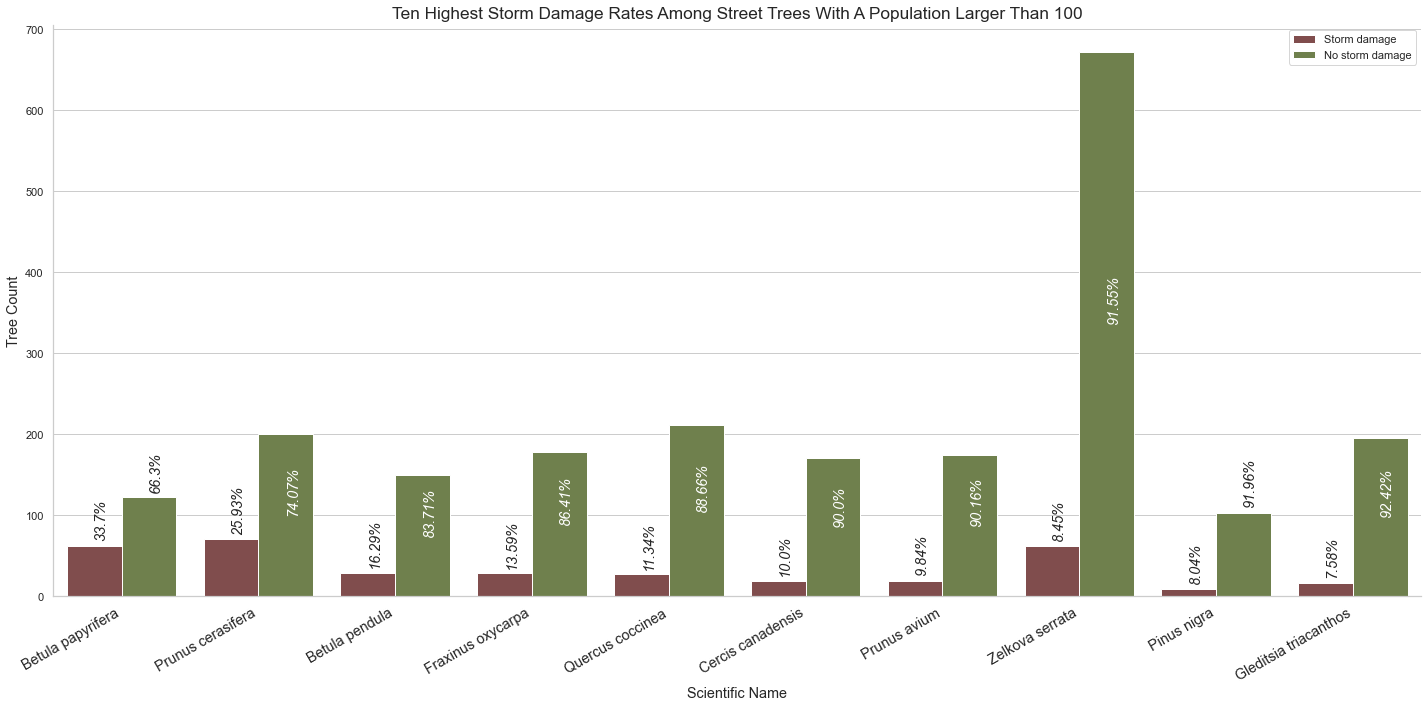

In [563]:
# Define order species will be plotted
species_order = top_ten_dmg['ScientificName']

# Define color palette
palette = [palette_dict['Removed, no stump'], palette_dict['No damage']]

# Plot data
catp = sns.catplot(x="ScientificName", kind="count", palette = palette, hue = 'storm_dmg', hue_order = ['Storm damage', 
                                                                                                        'No storm damage'],
                   order = species_order, legend = False,
                   data= over_hundred_dmg, height = 10, aspect = 2)

# Label patches
catLabel(catp, removed_dmg, 130, 10)

# Edit decorations
catp.ax.set_title('Ten Highest Storm Damage Rates Among Street Trees With A Population Larger Than 100', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

# Most Common Species of Street Tree

## *What are the 10 most common species of street tree in Wilsonville?*
 

In [564]:
# Group by scientific name and get count for each species. Add and calculate column for percentage of population for each species
species_data = tree_df.groupby(["ScientificName"]).size().reset_index(name = 'count')
species_data["percent_pop"] = species_data['count']/len(tree_df.index) *100

In [565]:
# Display top ten species
top_ten_species = species_data.nlargest(10, 'percent_pop')
top_ten_species

,ScientificName,count,percent_pop
32,Acer rubrum,2395,9.212601
260,Quercus rubra,1536,5.908374
25,Acer palmatum,1470,5.654499
29,Acer platanoides 'Emerald Queen',1045,4.019695
242,Pyrus calleryana,1005,3.865831
241,Pseudotsuga menziesii,910,3.500404
333,Zelkova serrata,734,2.823403
27,Acer platanoides 'Crimson King',559,2.150248
125,Fraxinus pennsylvanica,557,2.142555
303,Thuja plicata,553,2.127169


In [566]:
# Create df to make count plot and prepare for charting
plot_species = tree_df[(tree_df["ScientificName"].isin(top_ten_species['ScientificName']))]
species_order = top_ten_species["ScientificName"]
percent_pop = top_ten_species['percent_pop']

In [567]:
# Generate green palette for chart based on custom palette from before
multiplier = 1
species_palette = {}
base_green = palette_dict['No damage']
key = 'green'
keyno = 1

for species in range(10):
    newkey = key + str(keyno)
    new_green_val = list(base_green)[1] * multiplier
    species_palette[newkey] = [base_green[0], new_green_val, base_green[2]]
    keyno  += 1
    multiplier += .07
chart_palette = [species_palette[green] for green in species_palette]
chart_palette = [palette_dict['No damage'] for i in range(10)]

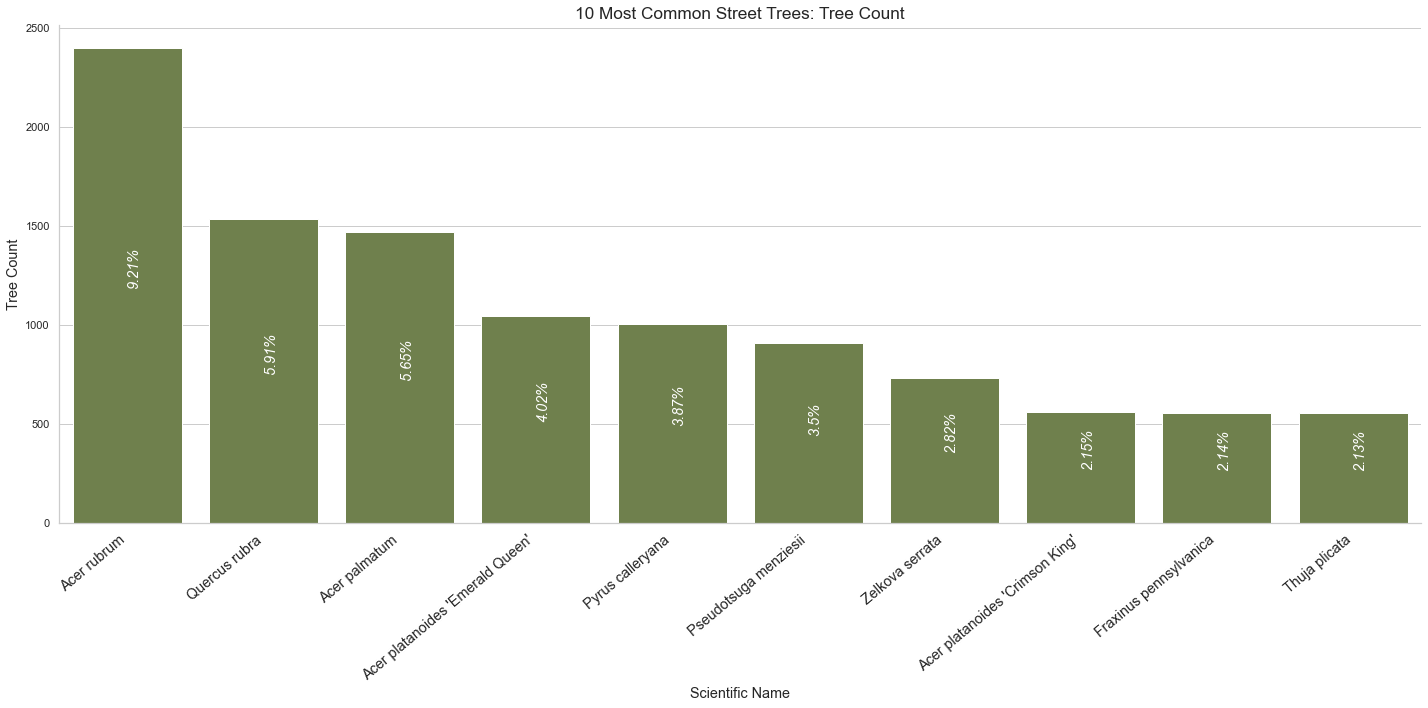

In [568]:
# Create bar plot displayin the top ten street tree species in Wilsonville
    
catp = sns.catplot(x="ScientificName", kind="count", palette = chart_palette, order = species_order, 
                   data= plot_species, height = 10, aspect = 2)

# label patches
catLabel(catp, percent_pop, 0)

#Edit decorations
catp.ax.set_title('10 Most Common Street Trees: Tree Count', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(), rotation = 40, ha = 'right', fontsize = 'large')
plt.tight_layout()
plt.show()

## *How do the top ten species break down in terms of tree status categories?*


In [569]:
# creat data frame that displays tree_status breakdowns for top ten species of trees
top_species_status = plot_species.groupby(["ScientificName", "tree_status"])['tree_status'].size().reset_index(
    name = 'status_count')
top_species_status = top_species_status.merge(top_ten_species[["ScientificName", "count"]])
top_species_status = top_species_status.rename(columns = {'ScientificName': 'scientific_name', 'count': 'species_count'})
top_species_status['status_percent'] = top_species_status['status_count']/top_species_status['species_count'] * 100
top_species_status

,scientific_name,tree_status,status_count,species_count,status_percent
0,Acer palmatum,"Removed, stump present",9,1470,0.612245
1,Acer palmatum,"Removed, no stump",100,1470,6.802721
2,Acer palmatum,No damage,1350,1470,91.836735
3,Acer palmatum,"Damaged, needs removal",1,1470,0.068027
4,Acer palmatum,"Damaged, may need removal - follow up required",10,1470,0.680272
5,Acer platanoides 'Crimson King',"Removed, stump present",4,559,0.715564
6,Acer platanoides 'Crimson King',"Removed, no stump",25,559,4.472272
7,Acer platanoides 'Crimson King',No damage,528,559,94.454383
8,Acer platanoides 'Crimson King',"Damaged, needs removal",0,559,0.000000
9,Acer platanoides 'Crimson King',"Damaged, may need removal - follow up required",2,559,0.357782


In [624]:
# Add missing status categories for tree species
trees_missing_status = ["Quercus rubra", "Acer platanoides 'Emerald Queen'", "Pseudotsuga menziesii", 
                        "Acer platanoides 'Crimson King'", "Thuja plicata"]

tree_list = []

for tree in trees_missing_status:
    species_total_sub = top_species_status[top_species_status['scientific_name'] == tree]
    species_total = species_total_sub.to_numpy()[0,3]
    if tree!= "Pseudotsuga menziesii":
        new_list = tree_list.append([tree, 'Damaged, needs removal', 0, species_total, 0])
    else:
        new_list = tree_list.append([tree, 'Damaged, may need removal - follow up required', 0, species_total, 0])
        new_list = tree_list.append([tree, 'Damaged, needs removal', 0, species_total, 0])


new_df = pd.DataFrame(tree_list, columns = top_species_status.columns)

In [625]:
# Append new df to top species df
top_species_status = top_species_status.append(new_df)

In [572]:
# Sort in preparation for charting
top_species_status = top_species_status.sort_values(by=['tree_status', 'species_count'], ascending = False)

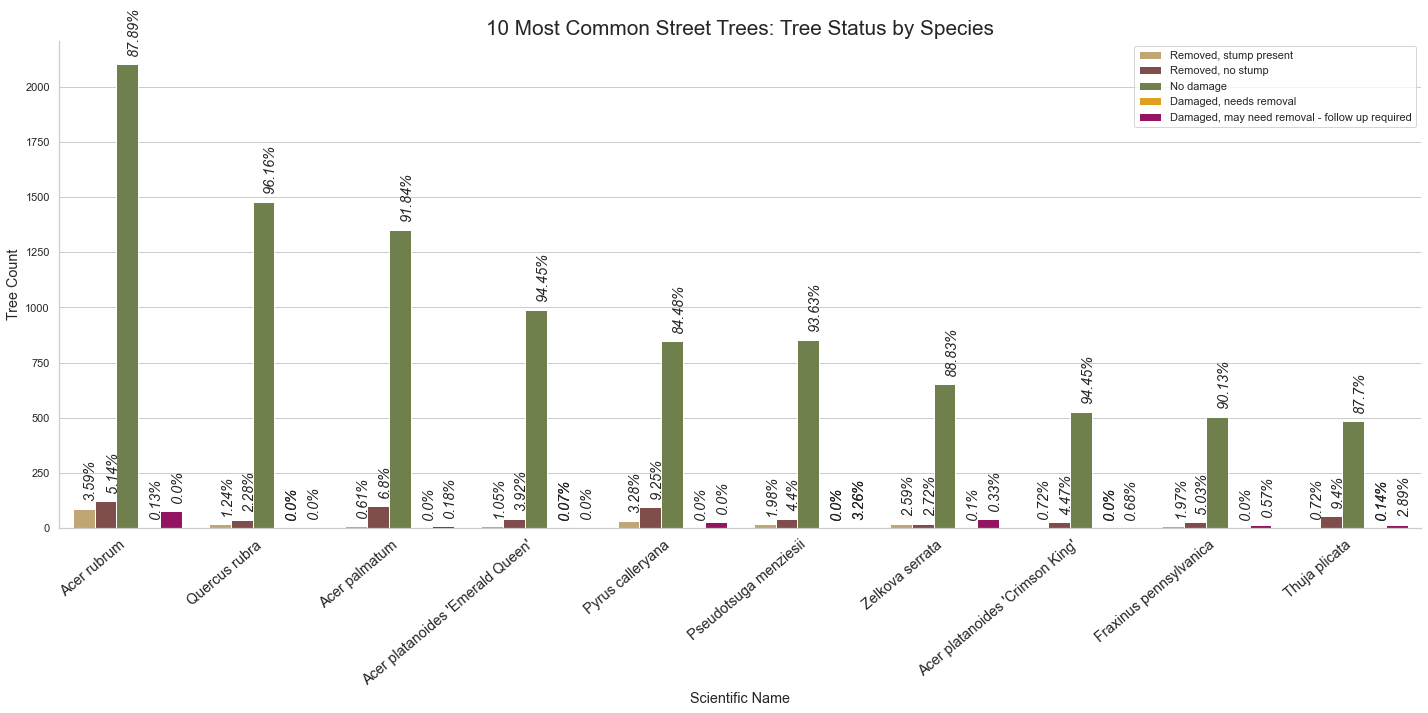

In [573]:
# Define plotting hue plotting order and labelling order
status_percent = top_species_status['status_percent']
tree_status = top_species_status['tree_status']   
hue_order = ['Removed, stump present', 'Removed, no stump', 'No damage', 
             'Damaged, needs removal', 'Damaged, may need removal - follow up required']

# Plot data
catp = sns.catplot(x="ScientificName", hue= "tree_status", hue_order =  hue_order, legend = False, kind="count", 
                   height = 10, aspect = 2, order = species_order, data= plot_species, palette = custom_palette)

# Label patches
catLabel(catp, status_percent)
        
#Edit decorations  
catp.ax.set_title('10 Most Common Street Trees: Tree Status by Species', fontsize = 'xx-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(), rotation = 40, ha = 'right', fontsize = 'large')
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

## *In the top ten trees, which had the lowest and highest rates of removal?*

In [627]:
plot_species.loc[:,'removed'] = np.where((plot_species['tree_status'] == 'Removed, stump present')|(plot_species['tree_status'] == 'Removed, no stump'), 'Removed', 'Not removed')
top_species_removed = plot_species.groupby(["ScientificName", "removed"])['removed'].size().reset_index(name = "removed_count")
top_species_removed = top_species_removed.merge(top_ten_species[['ScientificName', 'count']])
top_species_removed.loc[:,'percent_removed'] = top_species_removed['removed_count']/top_species_removed['count'] * 100


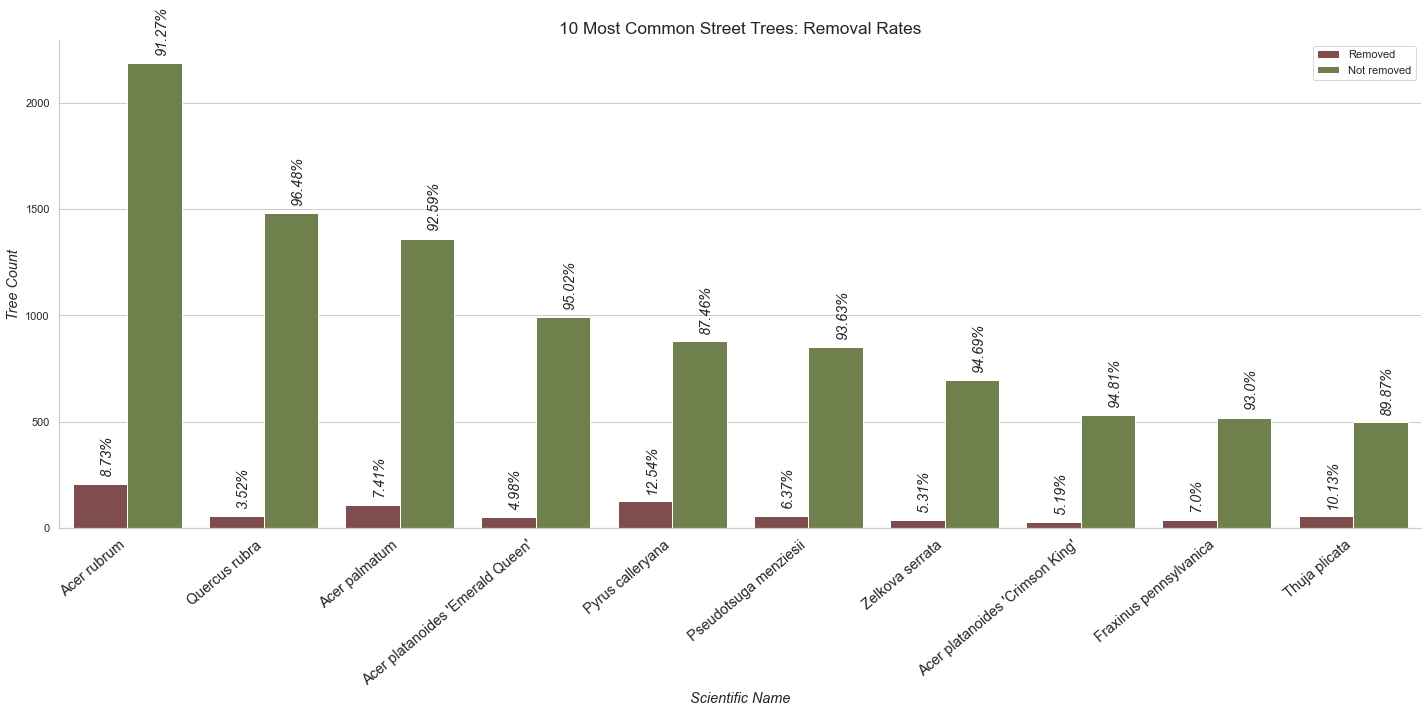

In [575]:
#Create count plots based on tree status and species

top_species_removed = top_species_removed.sort_values(by=['removed','count'], ascending = False)

status_percent = top_species_removed['percent_removed']
removed_status = top_species_removed['removed']   
hue_order = ['Removed', 'Not removed']
removed_palette = [palette_dict['Removed, no stump'], palette_dict['No damage']]



catp = sns.catplot(x="ScientificName", hue= "removed", hue_order =  hue_order, legend = False, kind="count", 
                   height = 10, aspect = 2, order = species_order, data= plot_species, palette = removed_palette)

catLabel(catp, status_percent)
        
  
catp.ax.set_title('10 Most Common Street Trees: Removal Rates', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large', fontstyle = 'oblique')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large', fontstyle = 'oblique')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(), rotation = 40, ha = 'right', fontsize = 'large')
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

In [576]:
removed_stats = top_species_removed[top_species_removed['removed']=='Removed']

print('Three tree species with highest removal rates:')
removed_stats.nlargest(3, 'percent_removed')[['ScientificName','percent_removed']]

Three tree species with highest removal rates:


,ScientificName,percent_removed
13,Pyrus calleryana,12.537313
17,Thuja plicata,10.126582
7,Acer rubrum,8.726514


In [577]:
print('Three tree species with lowest removal rates:')
removed_stats.nsmallest(3, 'percent_removed')[['ScientificName','percent_removed']]


Three tree species with lowest removal rates:


,ScientificName,percent_removed
15,Quercus rubra,3.515625
5,Acer platanoides 'Emerald Queen',4.976077
3,Acer platanoides 'Crimson King',5.187835


In [578]:
removed_stats.sort_values('percent_removed', ascending = False)[['ScientificName', 'percent_removed']]

,ScientificName,percent_removed
13,Pyrus calleryana,12.537313
17,Thuja plicata,10.126582
7,Acer rubrum,8.726514
1,Acer palmatum,7.414966
9,Fraxinus pennsylvanica,7.001795
11,Pseudotsuga menziesii,6.373626
19,Zelkova serrata,5.313351
3,Acer platanoides 'Crimson King',5.187835
5,Acer platanoides 'Emerald Queen',4.976077
15,Quercus rubra,3.515625


## *Of the top 10 most common street trees, which trees suffered damage that could be attributed to the 2020 ice storm?*

> For this analysis, the 'removed no stump' category was omitted from the data since these trees were likely removed before the ice storm

In [579]:
ice_dmg = top_species_status[(top_species_status['tree_status'] != 'Removed, no stump') & 
                             (top_species_status['tree_status']!= 'No damage')]
ice_count = ice_dmg.groupby('scientific_name')['status_count'].sum().reset_index(name = 'ice_damage')
ice_count = ice_count.merge(ice_dmg[['scientific_name', 'species_count']], 'left').drop_duplicates()
ice_count['percent_damaged'] = ice_count['ice_damage']/ice_count['species_count']*100

print("Three tree species most damaged by ice storm:")
ice_count.nlargest(3,'percent_damaged')[['scientific_name','percent_damaged']]


Three tree species most damaged by ice storm:


,scientific_name,percent_damaged
33,Zelkova serrata,8.446866
11,Acer rubrum,6.972860
22,Pyrus calleryana,6.268657


In [580]:
print("Three tree species least damaged by ice storm")
ice_count.nsmallest(3, 'percent_damaged')[['scientific_name', 'percent_damaged']]

Three tree species least damaged by ice storm


,scientific_name,percent_damaged
3,Acer platanoides 'Crimson King',1.073345
0,Acer palmatum,1.360544
25,Quercus rubra,1.562500


In [581]:
ice_count.sort_values('percent_damaged', ascending = False)[['scientific_name', 'percent_damaged']]

,scientific_name,percent_damaged
33,Zelkova serrata,8.446866
11,Acer rubrum,6.972860
22,Pyrus calleryana,6.268657
14,Fraxinus pennsylvanica,4.847397
29,Thuja plicata,2.893309
17,Pseudotsuga menziesii,1.978022
7,Acer platanoides 'Emerald Queen',1.626794
25,Quercus rubra,1.562500
0,Acer palmatum,1.360544
3,Acer platanoides 'Crimson King',1.073345


In [582]:
plot_species['ice_dmg'] = np.where((plot_species['tree_status'] != 'No damage') & (plot_species['tree_status'] != 'Removed, no stump'), 'Ice storm damage', 'No ice storm damage')
top_ice = plot_species.groupby(["ScientificName", "ice_dmg"])['ice_dmg'].size().reset_index(name = "ice_dmg_count")
top_ice = top_ice.merge(top_ten_species[['ScientificName', 'count']])
top_ice['percent_ice_dmg'] = top_ice['ice_dmg_count']/top_ice['count'] *100


C:\Users\rhuerta\AppData\Local\ESRI\conda\envs\data-vis\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


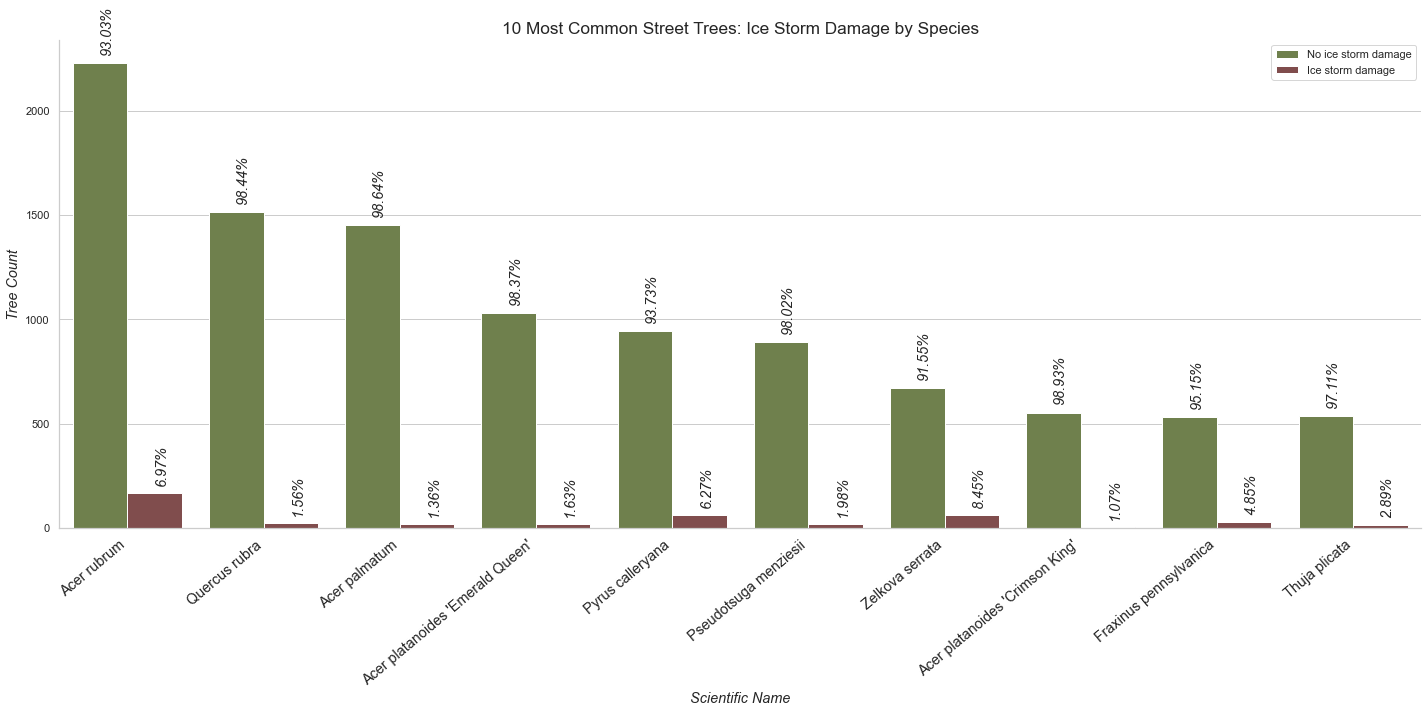

In [583]:
#Create count plots based on tree status and species


top_ice = top_ice.sort_values(by=['ice_dmg','count'], ascending = False)

status_percent = top_ice['percent_ice_dmg']
hue_order = ['No ice storm damage', 'Ice storm damage']
ice_palette = [palette_dict['No damage'], palette_dict['Removed, no stump']]



catp = sns.catplot(x="ScientificName", hue = 'ice_dmg', hue_order = hue_order, kind="count", legend = False,
                   height = 10, aspect = 2, order = species_order, data= plot_species, palette = ice_palette)

catLabel(catp, status_percent)
  
catp.ax.set_title('10 Most Common Street Trees: Ice Storm Damage by Species', fontsize = 'x-large')
catp.ax.set_xlabel ('Scientific Name', fontsize = 'large', fontstyle = 'oblique')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large', fontstyle = 'oblique')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(), rotation = 40, ha = 'right', fontsize = 'large')
plt.tight_layout()
plt.legend(loc = 'upper right')
plt.show()

# How  is Tree DBH (Diameter at Breast Height) distributed across status categories?

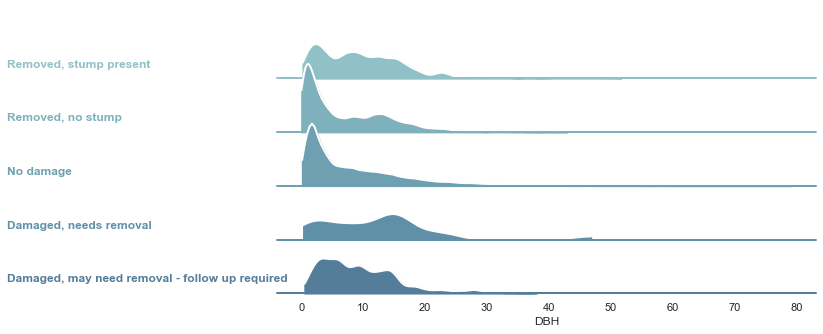

In [584]:
sns.set_theme(style='white', rc = {"axes.facecolor":(0,0,0,0)})
pal = sns.cubehelix_palette(10, rot = -.25, light = .7)
g = sns.FacetGrid(tree_df, row = "tree_status", hue = "tree_status", aspect = 15, height= 1
                  
                  , palette = pal)

g.map(sns.kdeplot, 'DBH',
     bw_adjust = .5, clip_on = False,
     fill = True, alpha = 1, linewidth = 1.5, cut = 0)
g.map(sns.kdeplot, 'DBH', clip_on=False, color = "w", lw = 2, bw_adjust = .5, cut = 0)
g.map(plt.axhline, y = 0, lw = 2, clip_on=False)

def label(x, color, label):
    ax = plt.gca()
    ax.text(-.5, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "DBH")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)
plt.show()

In [585]:
#Reset sns theme
sns.set_theme('notebook', 'whitegrid', 'mako')

In [586]:
tree_df['removed'] = np.where((tree_df['tree_status'] == 'Removed, stump present')|
                              (tree_df['tree_status'] == 'Removed, no stump'), 'Removed', 'Not removed')
tree_df['removed_no_stump'] = np.where((tree_df['tree_status'] == 'Removed, no stump'), True, False)

## *DBH kernel density  for removed versus not removed trees*

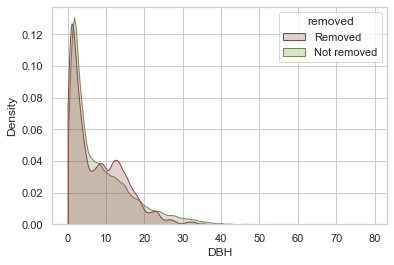

In [587]:
kde = sns.kdeplot(data = tree_df, x = "DBH", hue = "removed",  fill = True, bw_adjust = .5, 
                  palette = [palette_dict['Removed, no stump'], palette_dict['No damage']],
                  cut = 0, common_norm = False)


## *DBH kernel density for "removed no stump" versus other categories*

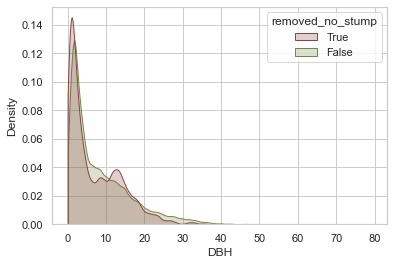

In [588]:
kde = sns.kdeplot(data = tree_df, x = "DBH", hue = "removed_no_stump",  fill = True, bw_adjust = .5,
                  palette =  [palette_dict['Removed, no stump'], palette_dict['No damage']],
                  hue_order = [True, False],
                  cut = 0, common_norm = False)

## *DBH rates across all trees*

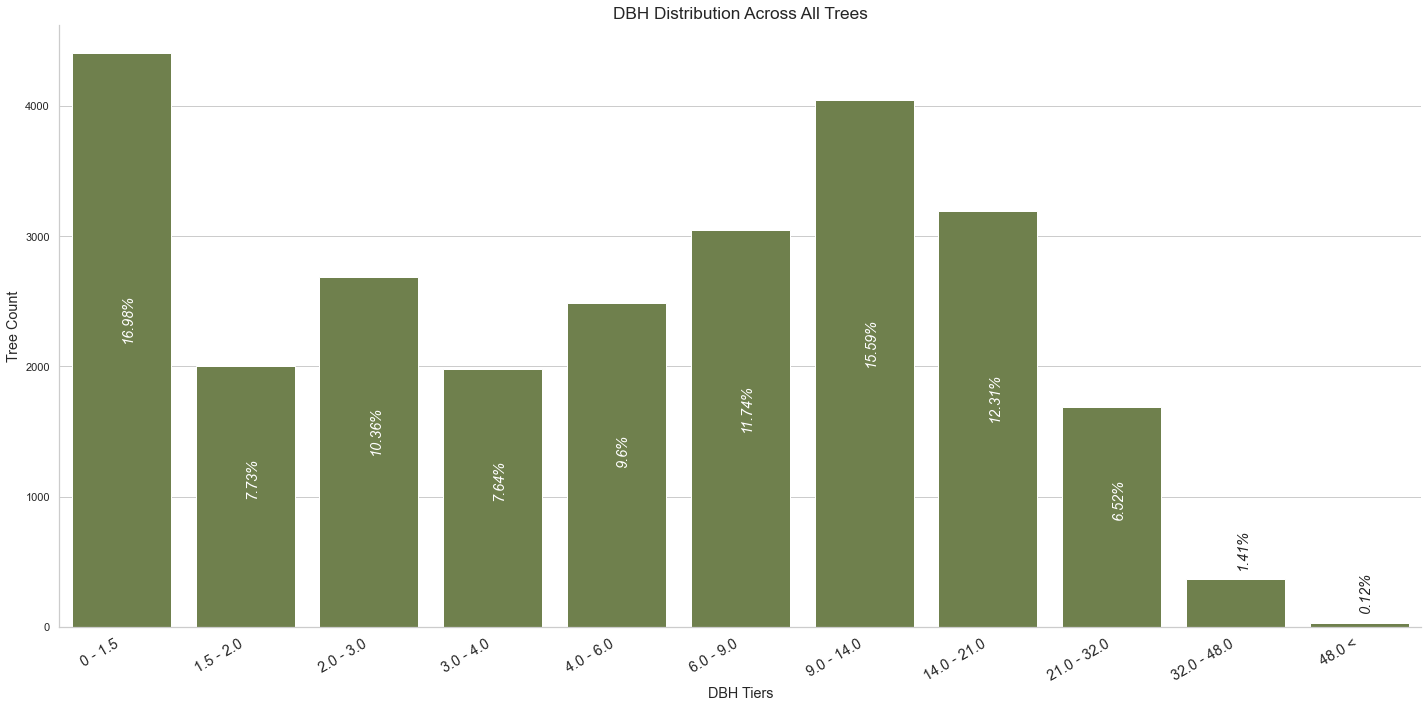

In [589]:
dbh_categories = classScheme(1.5, 50, 1.5, roundTo = 0)

conditions, values = conditionGen(dbh_categories, tree_df, 'DBH')

tree_df['DBH_tiers'] = np.select(conditions, values)  
tree_df['DBH_tiers'] = pd.Categorical(tree_df['DBH_tiers'], values)


dbh_perc = (tree_df['DBH_tiers'].value_counts(normalize=True)*100).reset_index().rename(
    columns = {'index':'DBH_tiers', 'DBH_tiers':'percent'}).sort_values('DBH_tiers')['percent'].tolist()


chart_palette = [palette_dict['No damage'] for x in range(7)]
catp = sns.catplot(x="DBH_tiers", kind="count", palette = chart_palette, order = values, 
                   data= tree_df, height = 10, aspect = 2)

catLabel(catp, dbh_perc, 500, add_height = 100)

catp.ax.set_title('DBH Distribution Across All Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('DBH Tiers', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

## *Tree removal rates by DBH*

In [590]:
tree_df['removed'] = np.where((tree_df['tree_status'] == 'Removed, stump present')|
                              (tree_df['tree_status'] == 'Removed, no stump'), 
                              'Removed', 'Not removed')


In [591]:
dbh_categories = classScheme(1.5, 50, 1.5)
conditions, values = conditionGen(dbh_categories, tree_df, 'DBH')


In [592]:
tree_df['DBH_tiers'] = np.select(conditions, values)  
tree_df['DBH_tiers'] = pd.Categorical(tree_df['DBH_tiers'], values)

In [593]:
tree_df = tree_df[tree_df.DBH_tiers != '0']
removed_trees = tree_df[(tree_df['removed']== 'Removed')]

In [594]:
dbh_perc = (removed_trees['DBH_tiers'].value_counts(normalize=True)*100).reset_index().rename(
    columns = {'index':'DBH_tiers', 'DBH_tiers':'percent'}).sort_values('DBH_tiers')['percent'].tolist()


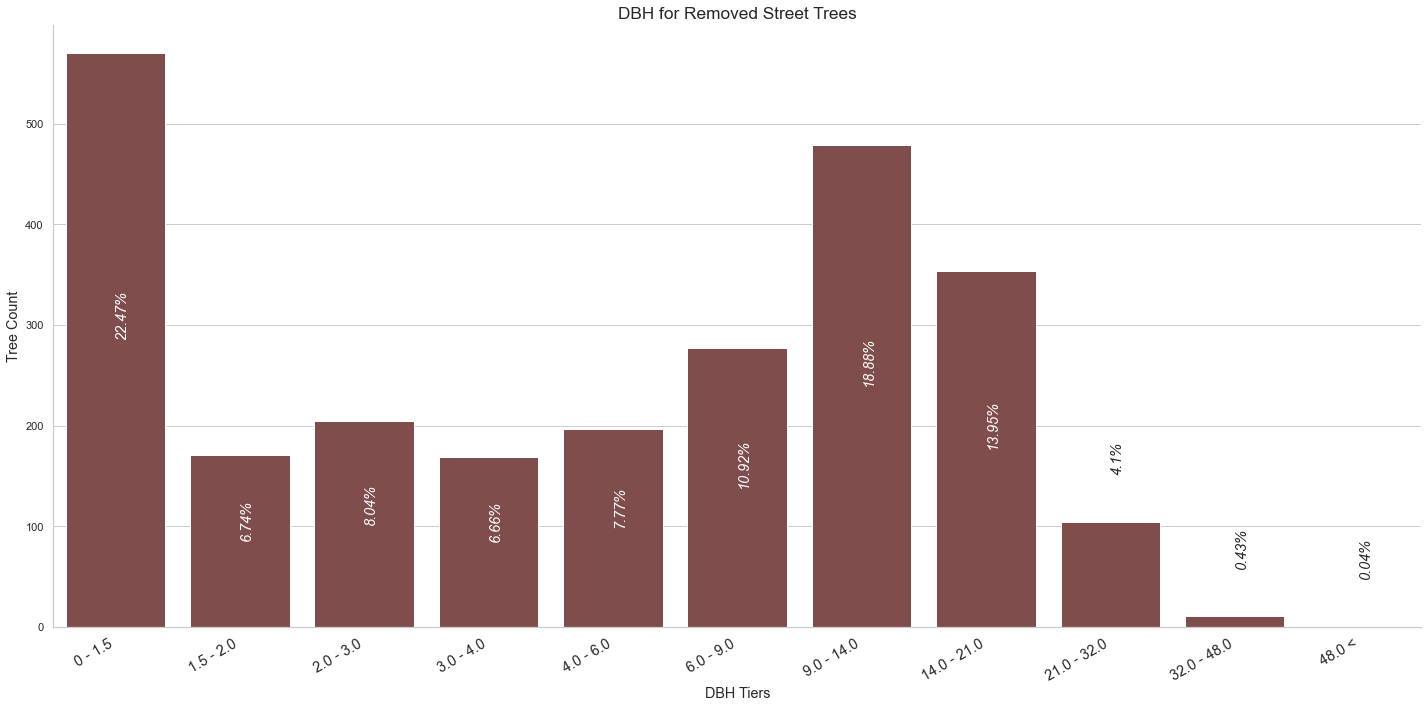

In [595]:
chart_palette = [palette_dict['Removed, no stump'] for x in range(7)]
catp = sns.catplot(x="DBH_tiers", kind="count", palette = chart_palette, order = values, 
                   data= tree_df[(tree_df['removed']== 'Removed')], height = 10, aspect = 2)

catLabel(catp, dbh_perc, 120)

catp.ax.set_title('DBH for Removed Street Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('DBH Tiers', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

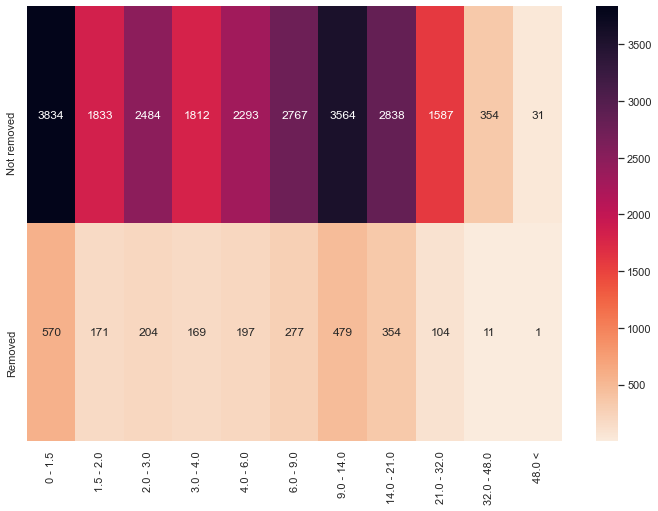

In [596]:
contingency = pd.crosstab(tree_df['removed'], tree_df['DBH_tiers'])
# Heat map for raw values
plt.figure(figsize = (12,8))
htmp = sns.heatmap(contingency, annot = True, fmt = 'd', cmap = sns.cm.rocket_r)
htmp.set_xlabel('')
htmp.set_ylabel('')
plt.show()

## *"Removed, no stump" rates by DBH*

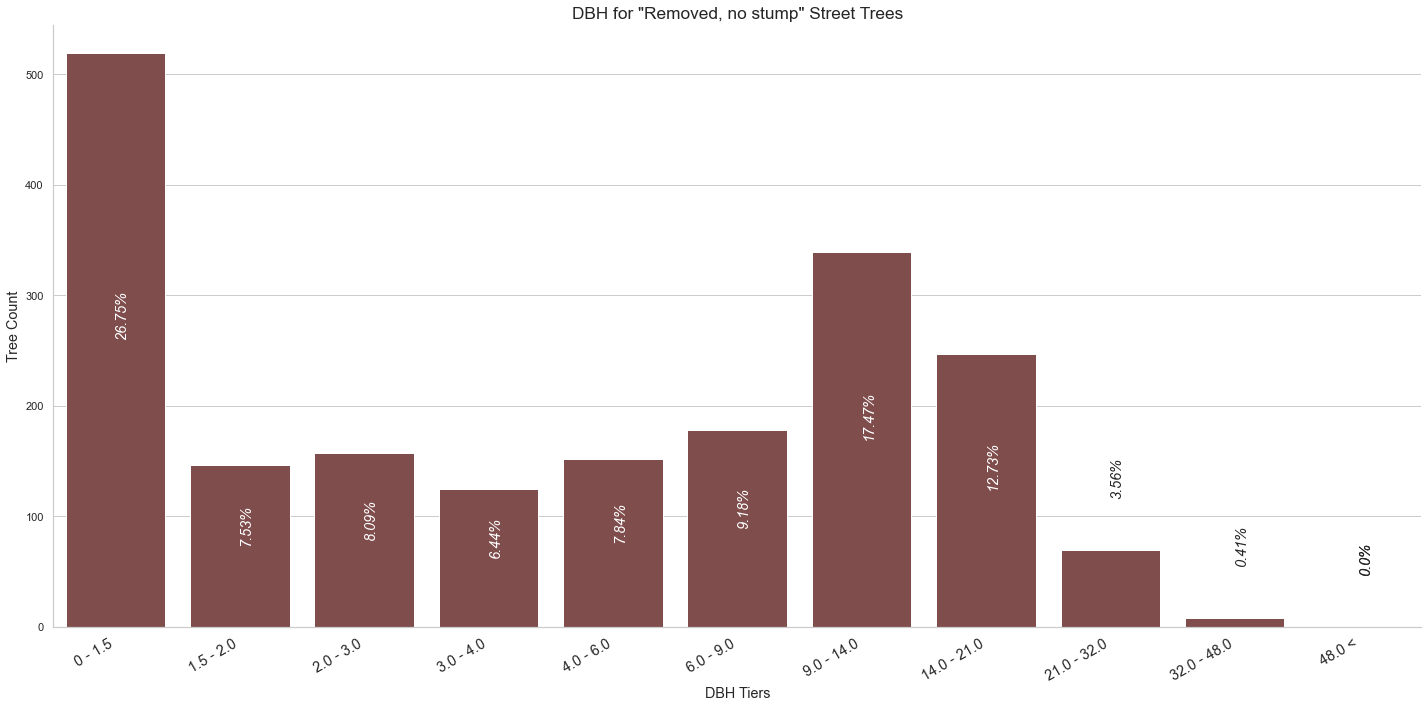

In [597]:
removed_no_stump = tree_df[(tree_df['removed_no_stump']== True)]
dbh_perc = (removed_no_stump['DBH_tiers'].value_counts(normalize=True)*100).reset_index().rename(
    columns = {'index':'DBH_tiers', 'DBH_tiers':'percent'}).sort_values('DBH_tiers')['percent'].tolist()

chart_palette = [palette_dict['Removed, no stump'] for x in range(7)]
catp = sns.catplot(x="DBH_tiers", kind="count", palette = chart_palette, order = values, 
                   data= removed_no_stump, height = 10, aspect = 2)

catLabel(catp, dbh_perc, 120)

catp.ax.set_title('DBH for "Removed, no stump" Street Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('DBH Tiers', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

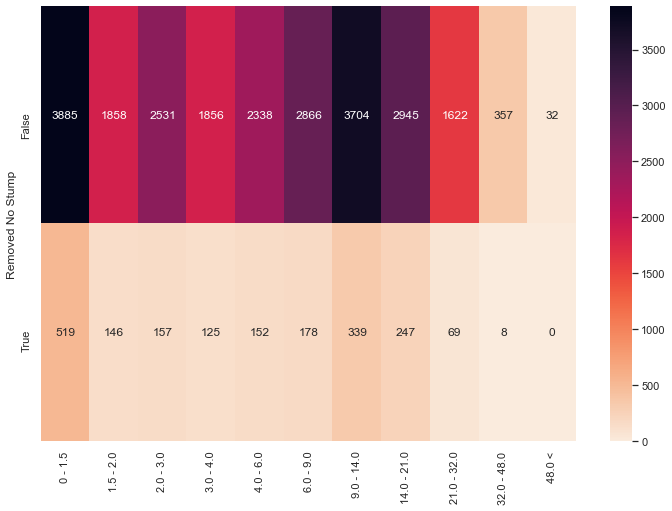

In [598]:
contingency = pd.crosstab(tree_df['removed_no_stump'], tree_df['DBH_tiers'])
# Heat map for raw values
plt.figure(figsize = (12,8))
htmp = sns.heatmap(contingency, annot = True, fmt = 'd', cmap = sns.cm.rocket_r)
htmp.set_xlabel('')
htmp.set_ylabel('Removed No Stump')
plt.show()

## *Tree removal rate with 6 DBH cutoff*


In [599]:
removed_df = tree_df[(tree_df.loc[:,'removed'] == 'Removed')]
categories = classScheme(6, 7, 2)

In [600]:
conditions, values = conditionGen(categories, removed_df, 'DBH')

In [601]:
removed_df.loc[:,'DBH_tiers'] = np.select(conditions, values)  
removed_df.loc[:,'DBH_tiers'] = pd.Categorical(removed_df.loc[:,'DBH_tiers'], values)

C:\Users\rhuerta\AppData\Local\ESRI\conda\envs\data-vis\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [602]:
dbh_perc = (removed_df['DBH_tiers'].value_counts(normalize=True)*100).reset_index().rename(
    columns = {'index':'DBH_tiers', 'DBH_tiers':'percent'}).sort_values('DBH_tiers')['percent'].tolist()

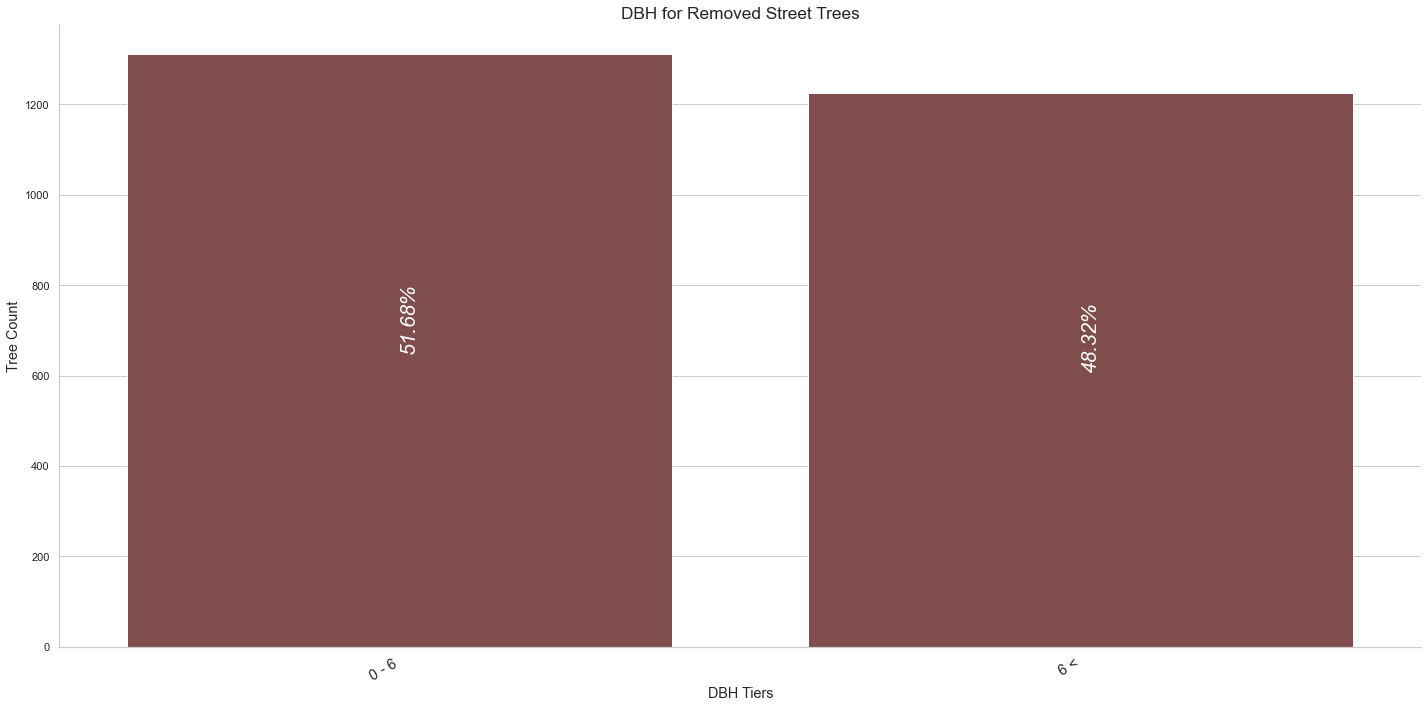

In [603]:
chart_palette = [palette_dict['Removed, no stump'] for x in range(7)]
catp = sns.catplot(x="DBH_tiers", kind="count", palette = chart_palette, order = values, data= removed_df, height = 10, aspect = 2)

catLabel(catp, dbh_perc, 120, fontsize = 'xx-large')

catp.ax.set_title('DBH for Removed Street Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('DBH Tiers', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

## *"Removed, no stump" rates with 6 DBH cutoff*

In [604]:
removed_no_stump = tree_df[(tree_df.loc[:,'removed_no_stump']== True)]

categories = classScheme(6, 7, 2)

conditions, values = conditionGen(categories, removed_no_stump, 'DBH')

removed_no_stump.loc[:,'DBH_tiers'] = np.select(conditions, values)  
removed_no_stump.loc[:,'DBH_tiers'] = pd.Categorical(removed_no_stump.loc[:,'DBH_tiers'], values)


C:\Users\rhuerta\AppData\Local\ESRI\conda\envs\data-vis\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


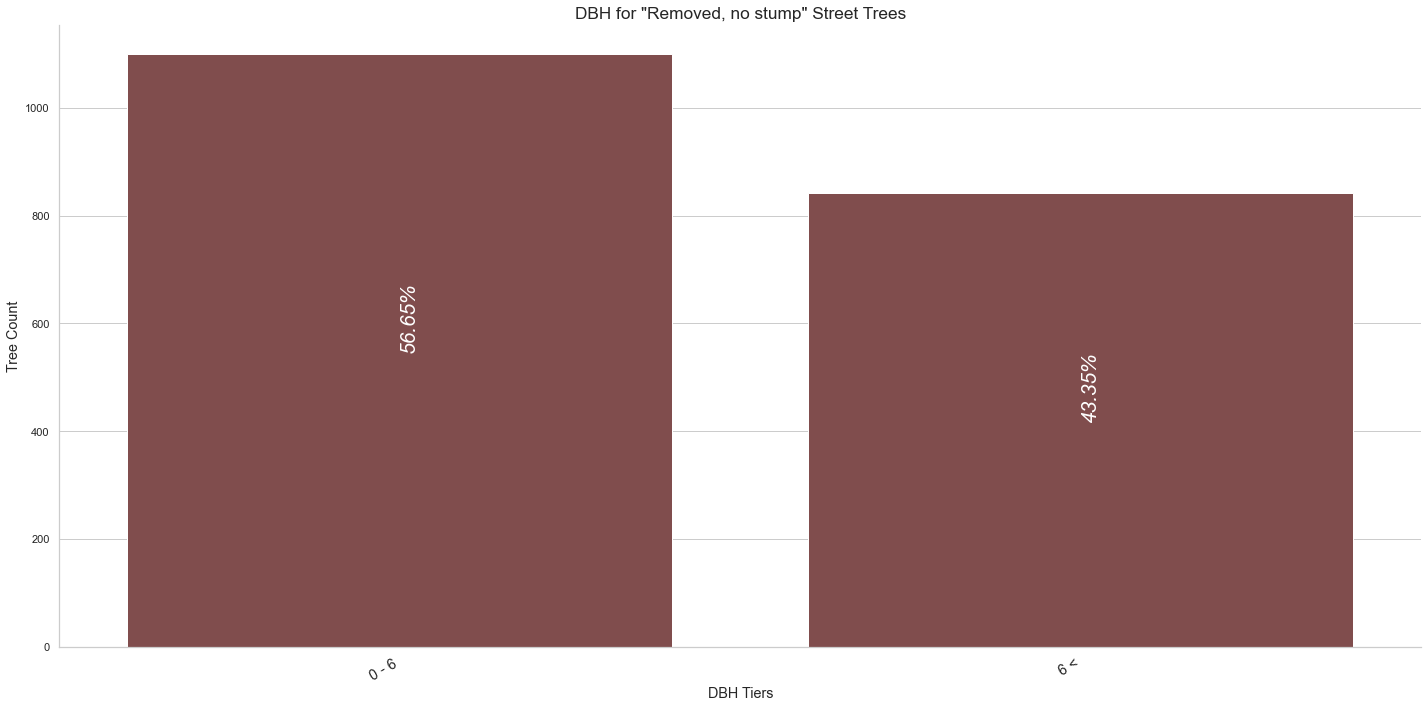

In [605]:

dbh_perc = (removed_no_stump['DBH_tiers'].value_counts(
    normalize=True)*100).reset_index().rename(
    columns = {'index':'DBH_tiers', 'DBH_tiers':'percent'}).sort_values('DBH_tiers')['percent'].tolist()

chart_palette = [palette_dict['Removed, no stump'] for x in range(7)]
catp = sns.catplot(x="DBH_tiers", kind="count", palette = chart_palette, order = values, 
                   data= removed_no_stump, height = 10, aspect = 2)

catLabel(catp, dbh_perc, 0, fontsize = 'xx-large')

catp.ax.set_title('DBH for "Removed, no stump" Street Trees', fontsize = 'x-large')
catp.ax.set_xlabel ('DBH Tiers', fontsize = 'large')   
catp.ax.set_ylabel('Tree Count', fontsize = 'large')
catp.ax.set_xticklabels(catp.ax.get_xticklabels(),ha = 'right', fontsize = 'large', rotation = 30)
plt.tight_layout()
plt.show()

# Health and tree_status correlation?

In [606]:
cont_tree_df = tree_df[tree_df['Health'] != ''].dropna(subset = ['Health'])
contingency = pd.crosstab(cont_tree_df['removed'], cont_tree_df['Health'])
contingency

Health,Dead,Healthy,In Decline,Stressed
removed,,,,
Not removed,121,20610,440,2227
Removed,170,2059,110,218


In [607]:
## Percent by tre_status
contingency_pct = pd.crosstab(cont_tree_df['removed'], cont_tree_df['Health'], normalize = 'columns')
contingency_pct

Health,Dead,Healthy,In Decline,Stressed
removed,,,,
Not removed,0.415808,0.909171,0.8,0.910838
Removed,0.584192,0.090829,0.2,0.089162


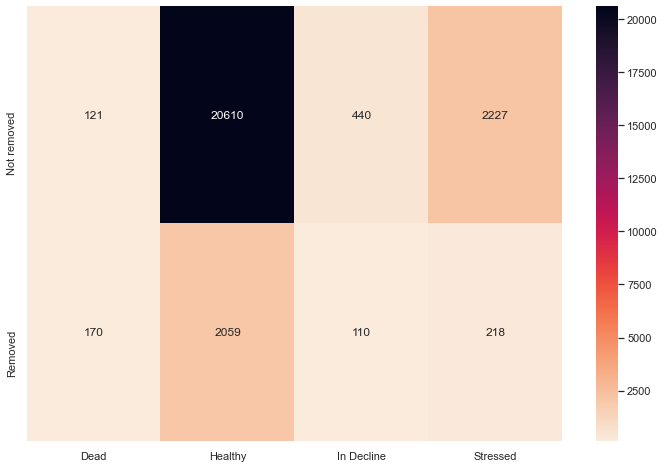

In [608]:
# Heat map for raw values
plt.figure(figsize = (12,8))
htmp = sns.heatmap(contingency, annot = True, fmt = 'd', cmap = sns.cm.rocket_r)
htmp.set_xlabel('')
htmp.set_ylabel('')
plt.show()

In [609]:
# Chi-square test of independence
stat, p, dof, expected = chi2_contingency(contingency)
print('dof=%d' % dof)
print(expected)

prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print("Dependent (reject H0)")
else:
    print("Independent (fail to reject H0)")

alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=3
[[  262.33165093 20435.72575612   495.8158351   2204.12675785]
 [   28.66834907  2233.27424388    54.1841649    240.87324215]]
probability=0.950, critical=7.815, stat=854.167
Dependent (reject H0)
significance=0.050, p=0.000
Dependent (reject H0)
